In [3]:
import pandas as pd

df = pd.read_csv("Medicaldataset.csv")

print(df.shape)
df.head()

(1319, 9)


,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


In [5]:
df["Result"].value_counts()

Result
positive    810
negative    509
Name: count, dtype: int64

In [6]:
from sklearn.preprocessing import LabelEncoder

# Codificar las etiquetas
label_encoder = LabelEncoder()
df["Result"] = label_encoder.fit_transform(df["Result"])
class_names = label_encoder.classes_
n_classes = len(class_names)
print("Clases:", list(class_names))

Clases: ['negative', 'positive']


In [8]:
caracteristicas = [] #almacenar los valores de las columnas que tengan el mismo tipo de dato

def tiene_mismo_valor(columna):
    return columna.unique().shape[0] == 1

for columna in df.columns:
    if tiene_mismo_valor(df[columna]):
        col = f"{columna}"
        caracteristicas.append(col)

print("Total de caracteristicas: ", len(caracteristicas))
print(caracteristicas)

#eliminamos las caracteristicas seleccionadas
df = df.drop(columns=caracteristicas)

Total de caracteristicas:  0
[]


In [9]:
import numpy as np

#eliminar valores duplicados del datframe
valores_duplicados = df.duplicated().sum()
print('Valores duplicados: ', valores_duplicados)

if(valores_duplicados>0):
    df=df.drop_duplicates()

# Contar los valores nulos
valores_nulos_por_columna = df.isnull().sum()

# Contar los valores infinitos positivos por columna
infinitos_positivos_por_columna = np.isinf(df).sum()

# Contar los valores infinitos negativos por columna
infinitos_negativos_por_columna = np.isneginf(df).sum()

print("Valores Nulos por Columna:", valores_nulos_por_columna.sum())
print("\nValores Infinitos Positivos por Columna:",infinitos_positivos_por_columna.sum())
print("\nValores Infinitos Negativos por Columna:",infinitos_negativos_por_columna.sum())


#Eliminar valores nulos, valores infinitos positivos y negativos
df = df.dropna().replace([np.inf, -np.inf], np.nan).dropna()


Valores duplicados:  0
Valores Nulos por Columna: 0

Valores Infinitos Positivos por Columna: 0

Valores Infinitos Negativos por Columna: 0


In [10]:
X = df.drop(columns=['Result'])
y = df['Result'].values

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)


print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")
print(f"Tamaño del conjunto de validación: {len(X_val)}")

Tamaño del conjunto de entrenamiento: 791
Tamaño del conjunto de prueba: 264
Tamaño del conjunto de validación: 264


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val= scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [13]:
resultados = pd.DataFrame(columns=['HPO','Accuracy', 'Precision', 'Recall','F1','MCC','GMean', 'Infer Time'])

### Hyperopt

In [14]:
from hyperopt import hp, fmin, tpe, Trials, space_eval
from hyperopt.pyll.base import scope
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, matthews_corrcoef, confusion_matrix)
from imblearn.metrics import geometric_mean_score

start_time = time.time()

def objective(params):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in skf.split(X_train, y_train):
        # Si X_train, y_train son arrays numpy:
        X_tr, X_val_fold = X_train[train_index], X_train[val_index]
        y_tr, y_val_fold = y_train[train_index], y_train[val_index]

        model_hpo = RandomForestClassifier(random_state=42, **params)
        model_hpo.fit(X_tr, y_tr)
        preds = model_hpo.predict(X_val_fold)
        acc = accuracy_score(y_val_fold, preds)
        scores.append(acc)

    # Devolver negativo para que Hyperopt minimice
    return -np.mean(scores)

space = {
        "n_estimators": scope.int(hp.uniform("n_estimators", 20, 150)),
        "max_depth": hp.choice("max_depth", [None] + list(range(3, 60))),
        "min_samples_split": scope.int(hp.uniform("min_samples_split", 2, 30)),
        "min_samples_leaf": scope.int(hp.uniform("min_samples_leaf", 1, 10)),
        "max_features": hp.choice("max_features", ["sqrt", "log2", None]),
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "class_weight": hp.choice("class_weight", [None, "balanced"]),
        "min_impurity_decrease": hp.loguniform("min_impurity_decrease",
                                           np.log(1e-9), np.log(1e-3)),
}

start_time = time.time()
trials = Trials()
best_params_hpo = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Mejores hiperparámetros:", space_eval(space, best_params_hpo))
print(f"Tiempo de búsqueda: {time.time()-start_time:.4f} s")


100%|██████████| 20/20 [01:04<00:00,  3.25s/trial, best loss: -0.9898892405063291]
Mejores hiperparámetros: {'bootstrap': False, 'class_weight': None, 'max_depth': 20, 'max_features': None, 'min_impurity_decrease': 0.0002577580251845666, 'min_samples_leaf': 6, 'min_samples_split': 15, 'n_estimators': 111}
Tiempo de búsqueda: 64.9750 s


### RandomSearchCV

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, loguniform

start_time = time.time()

param_distributions = {
    # enteros uniformes (20..150)  -> randint(low, high+1)
    "n_estimators": randint(20, 151),

    # choice entre None y enteros 3..59
    "max_depth": [None] + list(range(3, 60)),

    # enteros uniformes (2..30) y (1..10)
    "min_samples_split": randint(2, 31),
    "min_samples_leaf":  randint(1, 11),

    # categóricos
    "max_features": ["sqrt", "log2", None],
    "bootstrap":    [True, False],
    "class_weight": [None, "balanced"],

    # float log-uniforme en [1e-9, 1e-3]
    "min_impurity_decrease": loguniform(1e-9, 1e-3),
}

# Modelo base
model = RandomForestClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=20,                 # número de combinaciones aleatorias
    scoring='accuracy',        # o 'f1_weighted'
    cv=10,                      # Stratified K-Fold
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Entrenar
random_search.fit(X_train, y_train)

best_params_rs = random_search.best_params_
print("Mejor score CV:", random_search.best_score_)
print("Mejores hiperparámetros:", best_params_rs)
print(f"Tiempo de búsqueda: {time.time()-start_time:.4}s")

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Mejor score CV: 0.9860759493670885
Mejores hiperparámetros: {'bootstrap': False, 'class_weight': None, 'max_depth': 3, 'max_features': 'log2', 'min_impurity_decrease': np.float64(1.8794668241638476e-08), 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 77}
Tiempo de búsqueda: 31.62s


### BayesSearchCV

In [16]:
import time
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

# Definir espacio de búsqueda bayesiano
search_spaces = {
    "n_estimators": Integer(20, 150),                 # enteros inclusivos
    "max_depth": Categorical([None] + list(range(3, 60))),  # None o 3..59
    "min_samples_split": Integer(2, 30),
    "min_samples_leaf":  Integer(1, 10),
    "max_features": Categorical(["sqrt", "log2", None]),
    "bootstrap":    Categorical([True, False]),
    "class_weight": Categorical([None, "balanced"]),
    "min_impurity_decrease": Real(1e-9, 1e-3, prior="log-uniform"),
}

# Modelo base
model = RandomForestClassifier(random_state=42)

# Configuración de BayesSearchCV
opt = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=20,                # número de iteraciones de búsqueda bayesiana
    cv=10,                    # validación cruzada estratificada k=10
    scoring='accuracy',       # métrica de evaluación
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Entrenar
start_time = time.time()
opt.fit(X_train, y_train)

# Resultados
best_params_bs = opt.best_params_
print("Mejor score CV:", opt.best_score_)
print("Mejores hiperparámetros (BayesSearchCV):", best_params_bs)
print(f"Tiempo de búsqueda: {time.time()-start_time:.4f} s")


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

### Optuna

In [17]:
import optuna
import time
from sklearn.model_selection import cross_val_score
import numpy as np

# Función objetivo para Optuna
def objective(trial):
    # Espacio de búsqueda
    n_estimators= trial.suggest_int("n_estimators", 20, 150)
    min_samples_split =trial.suggest_int("min_samples_split", 2, 30)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

        # categóricos (incluye None)
    max_depth =trial.suggest_categorical("max_depth", [None] + list(range(3, 60)))
    max_features =trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap =trial.suggest_categorical("bootstrap", [True, False])
    class_weight =trial.suggest_categorical("class_weight", [None, "balanced"])

    model = RandomForestClassifier(
        n_estimators = n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_depth=max_depth,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weight,
    )

    # Validación cruzada 10-fold
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    return np.mean(scores)

# Ejecutar la optimización
start_time = time.time()
study = optuna.create_study(direction='maximize')  # queremos maximizar la métrica
study.optimize(objective, n_trials=20, n_jobs=-1)  # número de ensayos

print("Mejor score CV:", study.best_value)
print("Mejores hiperparámetros:", study.best_params)
print(f"Tiempo de búsqueda: {time.time()-start_time:.4f} s")

# Entrenar modelo final con los mejores hiperparámetros
best_params_opt = study.best_params


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-28 22:22:58,117] A new study created in memory with name: no-name-d9e57dcd-7401-4969-8b9b-32df24f94c0c
[I 2025-12-28 22:23:02,401] Trial 1 finished with value: 0.9835443037974683 and parameters: {'n_estimators': 44, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_depth': 38, 'max_features': None, 'bootstrap': True, 'class_weight': None}. Best is trial 1 with value: 0.9835443037974683.
[I 2025-12-28 22:23:02,882] Trial 0 finished with value: 0.9860759493670885 and parameters: {'n_estimators': 89, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_depth': 47, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced'}. Best 

Mejor score CV: 0.9860759493670885
Mejores hiperparámetros: {'n_estimators': 89, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_depth': 47, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced'}
Tiempo de búsqueda: 27.8874 s


### Método Propio

In [18]:
# ===========================================================
# HOPE-ML++ GENÉRICO (surrogate + UCB + mutación + ε-greedy)
# ===========================================================
import numpy as np
import time
from dataclasses import dataclass
from typing import Dict, Any, List, Tuple, Callable

from joblib import Parallel, delayed

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import check_random_state

# -----------------------
# Utilidades generales
# -----------------------
RNG_SEED = 42
rs = check_random_state(RNG_SEED)

def combined_reward(f1w: float, mcc: float, eps: float = 1e-9) -> float:
    """Media armónica entre F1 ponderado y MCC normalizado [0,1]."""
    mcc01 = (mcc + 1.0) / 2.0
    return 2.0 * (f1w * mcc01) / (f1w + mcc01 + eps)

def _to_numpy(X):
    if hasattr(X, "to_numpy"):
        return X.to_numpy()
    return np.asarray(X)

def _to_numpy_vec(y):
    return np.asarray(y)

# ------------------------------------------
# Evaluación CV en paralelo (modelo genérico)
# ------------------------------------------
def cv_score_generic(
    estimator_factory: Callable[[Dict[str, Any]], Any],
    params: Dict[str, Any],
    X, y,
    n_splits: int = 10,
    n_jobs: int = -1,
    random_state: int = RNG_SEED
) -> Tuple[float, Dict[str, float]]:
    """
    Evalúa (F1 weighted, MCC) con StratifiedKFold.
    - Si 'params' incluye '_thr' y el modelo soporta predict_proba, aplica umbral para binario.
    - Devuelve recompensa armónica F1w+MCC normalizado y métricas promedio.
    - Robusto: ante error penaliza con recompensa muy baja.
    """
    X = _to_numpy(X)
    y = _to_numpy_vec(y)

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    is_binary = np.unique(y).size == 2
    thr = params.get("_thr", None)

    def fit_score(train_idx, test_idx):
        Xtr, Xte = X[train_idx], X[test_idx]
        ytr, yte = y[train_idx], y[test_idx]

        clf = estimator_factory(params)
        try:
            clf.fit(Xtr, ytr)
            if is_binary and (thr is not None) and hasattr(clf, "predict_proba"):
                proba = clf.predict_proba(Xte)[:, 1]
                ypred = (proba >= float(thr)).astype(yte.dtype)
            else:
                ypred = clf.predict(Xte)
            f1w = f1_score(yte, ypred, average="weighted")
            mcc = matthews_corrcoef(yte, ypred)
        except Exception:
            # penaliza configuraciones inválidas para no detener la búsqueda
            f1w, mcc = 0.0, -1.0
        return f1w, mcc

    # CV en procesos para no anidar con hilos internos de sklearn
    results = Parallel(n_jobs=n_jobs, prefer="processes")(
        delayed(fit_score)(tr, te) for tr, te in cv.split(X, y)
    )
    f1s, mccs = zip(*results)
    f1w_mean = float(np.mean(f1s))
    mcc_mean = float(np.mean(mccs))
    reward = combined_reward(f1w_mean, mcc_mean)
    return reward, {
        "f1w": f1w_mean,
        "mcc": mcc_mean,
        "reward": reward,
        "f1w_std": float(np.std(f1s)),
        "mcc_std": float(np.std(mccs)),
    }

# -------------------------------------------------
# Declaración del espacio en formato estandarizado
# tipos soportados: int, int_log, float, float_log,
#                   int_or_none, cat
# -------------------------------------------------
# >>>>> EJEMPLO PARA RANDOMFORESTCLASSIFIER <<<<<
SPACE_RF = {
    "n_estimators": {"type": "int_log", "low": 20, "high": 150},
    "max_depth": {"type": "int_or_none", "low": 3, "high": 60, "p_none": 0.30},
    "min_samples_split": {"type": "int", "low": 2, "high": 30},
    "min_samples_leaf": {"type": "int", "low": 1, "high": 10},
    "max_features": {"type": "cat", "choices": ["sqrt", "log2", None]},
    "bootstrap": {"type": "cat", "choices": [True, False]},
    "class_weight": {"type": "cat", "choices": [None, "balanced"]},
    "min_impurity_decrease": {"type": "float_log", "low": 1e-9, "high": 1e-3},
    # Si tu sklearn>=1.1 puedes activar max_samples:
    # "max_samples": {"type": "float", "low": 0.4, "high": 1.0},
    # Meta-parámetro de decisión para binario:
    # "_thr": {"type": "float", "low": 0.1, "high": 0.9},
}

def rf_factory(params: Dict[str, Any]) -> RandomForestClassifier:
    # meta-params que no pertenecen al estimador
    meta_keys = {"_thr"}
    kwargs = {k: v for k, v in params.items() if k not in meta_keys}

    # compatibilidad: si class_weight es None, quítalo para algunas versiones
    if kwargs.get("class_weight", "KEEP") is None:
        kwargs.pop("class_weight", None)

    # constraint: max_samples solo si bootstrap=True
    if kwargs.get("bootstrap") is False and "max_samples" in kwargs:
        kwargs.pop("max_samples", None)

    return RandomForestClassifier(
        random_state=RNG_SEED,
        n_jobs=1,  # evita sobre-paralelización cuando CV usa procesos
        **kwargs
    )

# -------------------------------------------------------
# Samplers / Mutadores y codificador basados en SPACE
# -------------------------------------------------------
def _clip_int(v, low, high):
    return int(np.clip(int(round(v)), low, high))

def sample_one(name: str, spec: Dict[str, Any]) -> Any:
    t = spec["type"]
    if t == "int":
        return rs.randint(spec["low"], spec["high"] + 1)
    if t == "int_log":
        a, b = np.log10(spec["low"]), np.log10(spec["high"])
        return _clip_int(10 ** rs.uniform(a, b), spec["low"], spec["high"])
    if t == "float":
        return float(rs.uniform(spec["low"], spec["high"]))
    if t == "float_log":
        a, b = np.log10(spec["low"]), np.log10(spec["high"])
        return float(10 ** rs.uniform(a, b))
    if t == "int_or_none":
        if rs.rand() < spec.get("p_none", 0.2):
            return None
        return rs.randint(spec["low"], spec["high"] + 1)
    if t == "cat":
        return rs.choice(spec["choices"])
    raise ValueError(f"Tipo no soportado en {name}: {t}")

def mutate_one(name: str, spec: Dict[str, Any], val: Any, intensity: float) -> Any:
    t = spec["type"]
    if t == "int":
        span = max(1, int((spec["high"] - spec["low"]) * 0.15 * intensity))
        return _clip_int(val + rs.randint(-span, span + 1), spec["low"], spec["high"])

    if t == "int_log":
        a, b = np.log10(spec["low"]), np.log10(spec["high"])
        v = np.log10(val)
        v = np.clip(v + rs.normal(0, 0.35 * intensity), a, b)
        return _clip_int(10 ** v, spec["low"], spec["high"])

    if t == "float":
        step = (spec["high"] - spec["low"]) * 0.15 * intensity
        return float(np.clip(val + rs.normal(0, step), spec["low"], spec["high"]))

    if t == "float_log":
        a, b = np.log10(spec["low"]), np.log10(spec["high"])
        v = np.log10(val)
        v = np.clip(v + rs.normal(0, 0.35 * intensity), a, b)
        return float(10 ** v)

    if t == "int_or_none":
        if val is None:
            if rs.rand() < 0.25 * intensity:
                base = rs.randint(spec["low"], spec["high"] + 1)
                span = max(1, int((spec["high"] - spec["low"]) * 0.15 * intensity))
                return _clip_int(base + rs.randint(-span, span + 1), spec["low"], spec["high"])
            else:
                return None
        if rs.rand() < 0.10 * intensity:
            return None
        span = max(1, int((spec["high"] - spec["low"]) * 0.15 * intensity))
        return _clip_int(int(val) + rs.randint(-span, span + 1), spec["low"], spec["high"])

    if t == "cat":
        if rs.rand() < 0.25 * intensity:
            choices = [c for c in spec["choices"] if c != val]
            return rs.choice(choices) if choices else val
        return val

    raise ValueError(f"Tipo no soportado en {name}: {t}")

def sample_params_random(space: Dict[str, Dict[str, Any]]) -> Dict[str, Any]:
    return {k: sample_one(k, v) for k, v in space.items()}

def mutate_params(space: Dict[str, Dict[str, Any]], base: Dict[str, Any], intensity: float=0.25) -> Dict[str, Any]:
    out = base.copy()
    for k, spec in space.items():
        if rs.rand() < 0.6:  # no mutamos todos a la vez
            out[k] = mutate_one(k, spec, base[k], intensity)
    return out

# ----------------------------
# Codificación (orden estable)
# ----------------------------
def encode_params(space: Dict[str, Dict[str, Any]], p: Dict[str, Any], keys: List[str] = None) -> np.ndarray:
    keys = keys or list(space.keys())
    vecs = []
    for name in keys:
        spec = space[name]
        t = spec["type"]
        v = p[name]
        if t in ("int", "int_log"):
            if t == "int_log":
                vecs.append([np.log10(max(v, 1))])
            else:
                vecs.append([float(v)])
        elif t in ("float", "float_log"):
            if t == "float_log":
                vecs.append([np.log10(v)])
            else:
                vecs.append([float(v)])
        elif t == "int_or_none":
            val = 0.0 if v is None else float(v)
            flag = 1.0 if v is None else 0.0
            vecs.append([val, flag])
        elif t == "cat":
            choices = spec["choices"]
            one = np.zeros(len(choices), dtype=float)
            idx = choices.index(v)
            one[idx] = 1.0
            vecs.append(one.tolist())
        else:
            raise ValueError(f"Tipo no soportado en encode: {t}")
    return np.asarray(np.concatenate(vecs, axis=0), dtype=float)

# -----------------------------
# Adquisición: UCB sobre RF
# -----------------------------
@dataclass
class Trial:
    params: Dict[str, Any]
    x: np.ndarray
    reward: float
    metrics: Dict[str, float]

class HopeMLGeneric:
    def __init__(self,
                 space: Dict[str, Dict[str, Any]],
                 estimator_factory: Callable[[Dict[str, Any]], Any],
                 init_points: int = 24,
                 n_iter: int = 150,
                 top_k: int = 12,
                 candidates_per_iter: int = 256,
                 epsilon_start: float = 0.35,
                 epsilon_end: float = 0.05,
                 ucb_kappa: float = 1.5,
                 early_stopping_rounds: int = 25,
                 n_splits_cv: int = 10,
                 n_jobs_cv: int = -1,
                 random_state: int = RNG_SEED):
        self.space = space
        self.estimator_factory = estimator_factory
        self.init_points = init_points
        self.n_iter = n_iter
        self.top_k = top_k
        self.candidates_per_iter = candidates_per_iter
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.ucb_kappa = ucb_kappa
        self.early_stopping_rounds = early_stopping_rounds
        self.n_splits_cv = n_splits_cv
        self.n_jobs_cv = n_jobs_cv
        self.random_state = random_state

        # orden estable de claves del espacio
        self.space_keys = list(space.keys())

        self.trials: List[Trial] = []
        self.tried_signatures = set()
        self.surrogate = RandomForestRegressor(
            n_estimators=350,
            random_state=random_state,
            n_jobs=-1,
            bootstrap=True
        )

    def _signature(self, p: Dict[str, Any]) -> Tuple:
        sig = []
        for name in self.space_keys:
            spec = self.space[name]
            v = p[name]
            t = spec["type"]
            if t in ("float", "float_log"):
                sig.append((name, round(float(v), 10)))
            elif t == "int_log":
                sig.append((name, int(v)))
            else:
                sig.append((name, None if v is None else v))
        return tuple(sig)

    def _get_topk(self) -> List[Trial]:
        if not self.trials:
            return []
        return sorted(self.trials, key=lambda t: t.reward, reverse=True)[: self.top_k]

    def _epsilon(self, t: int) -> float:
        frac = min(1.0, max(0.0, t / max(1, self.n_iter - 1)))
        return self.epsilon_start + (self.epsilon_end - self.epsilon_start) * frac

    def _propose_candidates(self, n_rand: int, n_mut: int) -> List[Dict[str, Any]]:
        cand = [sample_params_random(self.space) for _ in range(n_rand)]
        topk = self._get_topk()
        if topk:
            for _ in range(n_mut):
                base = rs.choice(topk).params
                cand.append(mutate_params(self.space, base, intensity=0.25))
        else:
            cand += [sample_params_random(self.space) for _ in range(n_mut)]
        return cand

    def _acquisition_ucb(self, X: np.ndarray) -> np.ndarray:
        trees = [est for est in self.surrogate.estimators_]
        preds = np.vstack([t.predict(X) for t in trees])
        mu = preds.mean(axis=0)
        sigma = preds.std(axis=0)
        return mu + self.ucb_kappa * sigma

    def fit(self, X, y) -> Dict[str, Any]:
        start = time.time()
        X = _to_numpy(X)
        y = _to_numpy_vec(y)

        best_reward = -np.inf
        best_params = None
        best_metrics = None
        no_improve = 0

        # -------- Warm-start
        while len(self.trials) < self.init_points:
            p = sample_params_random(self.space)
            sig = self._signature(p)
            if sig in self.tried_signatures:
                continue
            reward, metrics = cv_score_generic(self.estimator_factory, p, X, y,
                                               n_splits=self.n_splits_cv,
                                               n_jobs=self.n_jobs_cv,
                                               random_state=self.random_state)
            self.trials.append(Trial(params=p,
                                     x=encode_params(self.space, p, self.space_keys),
                                     reward=reward, metrics=metrics))
            self.tried_signatures.add(sig)
            if reward > best_reward:
                best_reward, best_params, best_metrics = reward, p, metrics
                no_improve = 0

        # -------- Iteraciones
        for t in range(self.n_iter):
            Xs = np.vstack([tr.x for tr in self.trials])
            ys = np.array([tr.reward for tr in self.trials], dtype=float)
            self.surrogate.fit(Xs, ys)

            eps = self._epsilon(t)
            n_candidates = self.candidates_per_iter
            n_rand = int(n_candidates * (0.25 + eps * 0.5))
            n_mut = n_candidates - n_rand

            candidates = self._propose_candidates(n_rand, n_mut)
            filtered = [p for p in candidates if self._signature(p) not in self.tried_signatures]
            if not filtered:
                filtered = [sample_params_random(self.space) for _ in range(n_candidates)]

            Xcand = np.vstack([encode_params(self.space, p, self.space_keys) for p in filtered])

            if rs.rand() < eps:
                order = rs.permutation(len(filtered))
            else:
                ucb = self._acquisition_ucb(Xcand)
                order = np.argsort(-ucb)

            chosen = None
            for idx in order:
                p = filtered[int(idx)]
                sig = self._signature(p)
                if sig not in self.tried_signatures:
                    chosen = p
                    break
            if chosen is None:
                chosen = filtered[int(order[0])]

            reward, metrics = cv_score_generic(self.estimator_factory, chosen, X, y,
                                               n_splits=self.n_splits_cv,
                                               n_jobs=self.n_jobs_cv,
                                               random_state=self.random_state)
            tr = Trial(params=chosen,
                       x=encode_params(self.space, chosen, self.space_keys),
                       reward=reward, metrics=metrics)
            self.trials.append(tr)
            self.tried_signatures.add(self._signature(chosen))

            if reward > best_reward + 1e-10:
                best_reward, best_params, best_metrics = reward, chosen, metrics
                no_improve = 0
            else:
                no_improve += 1

            print(f"[{t+1:03d}/{self.n_iter}] best={best_reward:.6f} | "
                  f"F1w={best_metrics['f1w']:.6f}±{best_metrics.get('f1w_std',0):.4f} "
                  f"MCC={best_metrics['mcc']:.6f}±{best_metrics.get('mcc_std',0):.4f} | "
                  f"params={best_params}")

            if no_improve >= self.early_stopping_rounds:
                print(">> Early stopping por falta de mejora.")
                break

        elapsed = time.time() - start
        print(f"\nMejor recompensa: {best_reward:.6f}")
        print("Mejores hiperparámetros:", best_params)
        print("Mejores métricas:", best_metrics)
        print(f"Tiempo total: {elapsed:.2f}s | Evaluaciones: {len(self.trials)}")
        return {
            "best_params": best_params,
            "best_reward": best_reward,
            "best_metrics": best_metrics,
            "trials": self.trials,
            "elapsed_sec": elapsed,
        }

# =========================
# 1) USO CON RANDOM FOREST
# =========================
# Ejemplo de uso:
# X_train = X_train.values if hasattr(X_train, "values") else X_train
# y_train = y_train.values if hasattr(y_train, "values") else y_train

# Configura el optimizador
opt_rf = HopeMLGeneric(
    space=SPACE_RF,
    estimator_factory=rf_factory,
    init_points=24,
    n_iter=150,
    top_k=12,
    candidates_per_iter=256,
    epsilon_start=0.35,
    epsilon_end=0.05,
    ucb_kappa=1.5,
    early_stopping_rounds=25,
    n_splits_cv=10,
    n_jobs_cv=-1,       # CV en procesos. Si pones 1 aquí, puedes subir n_jobs en el estimador.
    random_state=RNG_SEED
)

# Entrenar el optimizador (asegúrate de tener X_train, y_train)
result_rf = opt_rf.fit(X_train, y_train)
best_params_rf = result_rf["best_params"]



[001/150] best=0.989671 | F1w=0.989877±0.0076 MCC=0.978931±0.0159 | params={'n_estimators': 43, 'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': np.False_, 'class_weight': None, 'min_impurity_decrease': 3.979692301055987e-09}
[002/150] best=0.989671 | F1w=0.989877±0.0076 MCC=0.978931±0.0159 | params={'n_estimators': 43, 'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': np.False_, 'class_weight': None, 'min_impurity_decrease': 3.979692301055987e-09}
[003/150] best=0.989671 | F1w=0.989877±0.0076 MCC=0.978931±0.0159 | params={'n_estimators': 43, 'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': np.False_, 'class_weight': None, 'min_impurity_decrease': 3.979692301055987e-09}
[004/150] best=0.989671 | F1w=0.989877±0.0076 MCC=0.978931±0.0159 | params={'n_estimators': 43, 'max_depth': 45, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_feature

### Evaluación de resultados finales

In [20]:
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
from imblearn.metrics import geometric_mean_score


def get_results(HPO, modelo_cl, X_train, y_train, X_val, y_val, X_test, y_test):

    global resultados

    X_final = np.vstack((X_train, X_val))
    y_final = np.concatenate((y_train, y_val))

    modelo = modelo_cl
    modelo.fit(X_final, y_final)

    start_time = time.time()
    y_pred = modelo.predict(X_test)

    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 4))  
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f'Matriz de confusión: {HPO}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    gmean = geometric_mean_score(y_test, y_pred, average='weighted')

    resultados = pd.concat([resultados, pd.DataFrame({
            'HPO': [HPO],
            'Accuracy': [accuracy], 
            'Precision': [precision], 
            'Recall': [recall], 
            'F1': [f1],
            'MCC': [mcc], 
            'GMean': [gmean],
            'Infer Time': [time.time()-start_time]
        })], ignore_index=True)


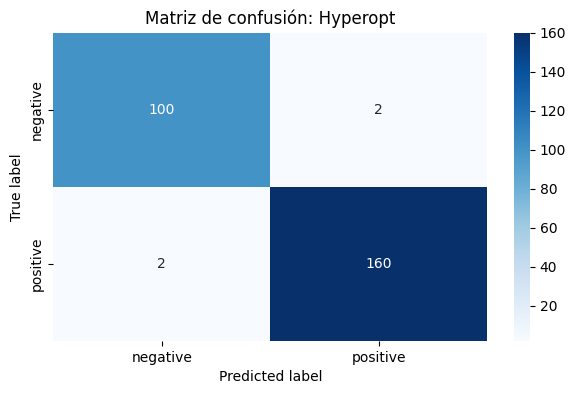

C:\Users\USER\AppData\Local\Temp\ipykernel_4228\2858447711.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = pd.concat([resultados, pd.DataFrame({


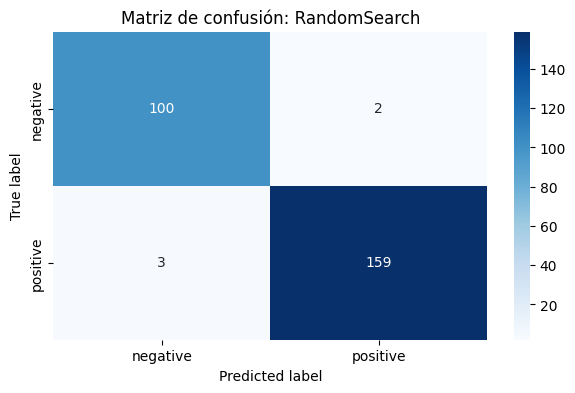

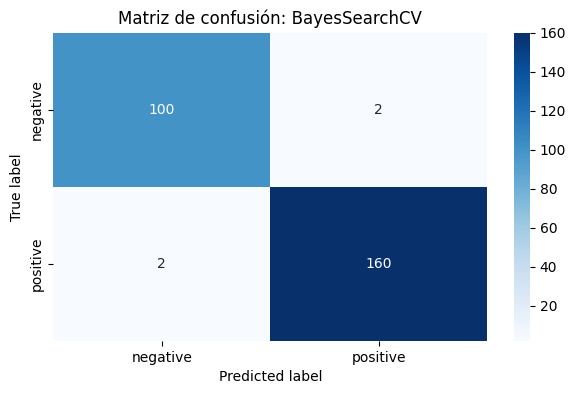

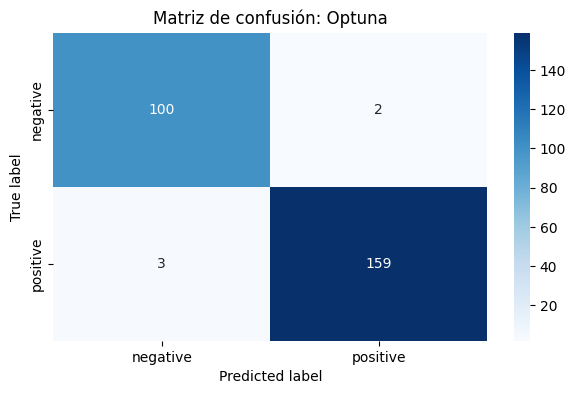

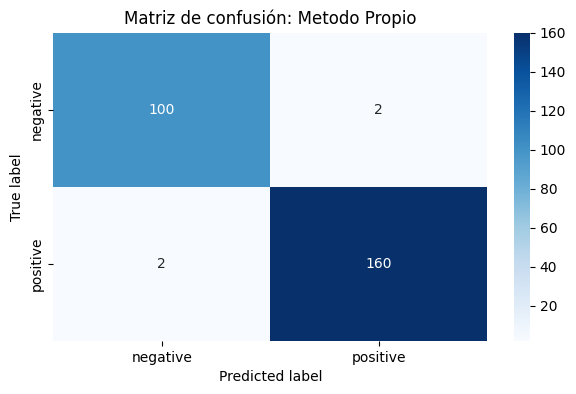


Resumen de resultados


,HPO,Accuracy,Precision,Recall,F1,MCC,GMean,Infer Time
0,Hyperopt,0.984848,0.984848,0.984848,0.984848,0.968046,0.984023,0.600818
1,RandomSearch,0.981061,0.981124,0.981061,0.981077,0.960161,0.980937,0.324600
2,BayesSearchCV,0.984848,0.984848,0.984848,0.984848,0.968046,0.984023,0.514625
3,Optuna,0.981061,0.981124,0.981061,0.981077,0.960161,0.980937,0.553522
4,Metodo Propio,0.984848,0.984848,0.984848,0.984848,0.968046,0.984023,0.339096


In [21]:
# === Lista de métodos de optimización ===
resultados.drop(resultados.index, inplace=True)

modelos = [
    ("Hyperopt", RandomForestClassifier(**space_eval(space, best_params_hpo))),
    ("RandomSearch", RandomForestClassifier(**best_params_rs)),
    ("BayesSearchCV", RandomForestClassifier(**best_params_bs)),
    ("Optuna", RandomForestClassifier(**best_params_opt)),
    ("Metodo Propio", RandomForestClassifier(**best_params_rf))
]

# === Entrenar y evaluar todos ===
for nombre, modelo in modelos:
    get_results(nombre, modelo, X_train, y_train, X_val, y_val, X_test, y_test)

# === Resumen ===
print("\nResumen de resultados")
resultados.head(10)